# Homework 2 
## Building a Machine Learning Model
### Purpose:
The purpose of this notebook is to practice building a regression model using the data provided by Kaggle in the House Prices: Advanced Regression challenge in order to predict house prices. 

### Credit:
Thanks to the [Kaggle Kernel of Sergine](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard) for help with the Box Cox transformation and some feature engineering ideas. 

Also a special thanks to [Conner Leavitt](https://github.com/Conner-Leavitt) for a large amount of motivation and for plenty of ideas and help.

# Table of Contents
1. Importing Data

2. Visualizing & Cleaning Data

3. Imputation & Feature Engineering

4. Model Selection & Hyperparameter Tuning

5. Ensembling Models


In [66]:
#Import libraries to visualize and clean data
import pandas as pd
import numpy as np

import seaborn as sns
#Set color palette for graphs
sns.set_palette(sns.color_palette('hls', 7))

import matplotlib.pyplot as plt
import scipy.stats
from scipy.stats import norm, skew #for some statistics
import time
from sklearn.preprocessing import LabelEncoder, RobustScaler

#Silencing deprication warnings
import warnings
warnings.filterwarnings("ignore")

#Import libraries for modeling and validation
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, train_test_split, learning_curve
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline, make_pipeline

#Import libraries for stacking 
from mlens.metrics.metrics import rmse
from mlens.visualization import corrmat
from mlens.ensemble import SuperLearner

# Importing Data

The first thing that we are going to do is import our data. From here there are a few important things we need to do before we start exploring our data. We need to go ahead and save our test set Id numbers in order to submit predictions later. After we do that, we will go ahead and take a high-level overview of our data. 

In [67]:
#Get the train and test data and merge them into one dataframe
train = pd.read_csv(r"C:\Users\nelso\OneDrive\Machine_Learning\Homeworks\HW2\Housing_Prices_Data\train.csv")
test = pd.read_csv(r"C:\Users\nelso\OneDrive\Machine_Learning\Homeworks\HW2\Housing_Prices_Data\test.csv")
Id = test.Id
train.shape[0]

1460

In [68]:
#Make sure the data read in okay
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


# Visualizing & Cleaning Data

Now we are going to visualize our data. The point of exploring our data is to understand our target variable a little bit better. So we are going to focus our efforts on understanding how some of the other variables we will eventually use for predictions interact with the sale price of houses. Since it is not a productive use of our time to do a deep dive into 80 different variables, we want to find out which variables are most correlated with the sale price and focus on those. Let's look at a heat map of correlations for the variables with a correlation above .5 with the price. 

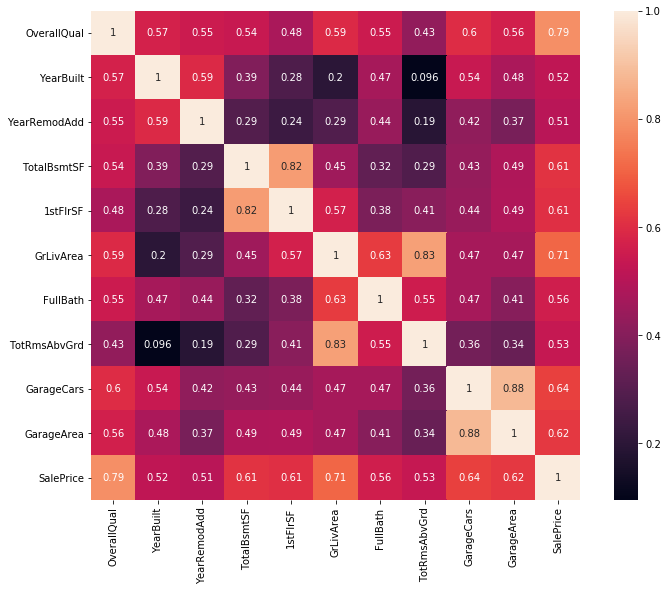

In [69]:
#Create a new set of correlation data. 
corr_train = train.corr()
#Select thevariables most correlated with sales price and show a heat map.
best_corr = corr_train.index[abs(corr_train["SalePrice"])>0.5]
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(train[best_corr].corr(), square = True, annot = True)

In the correlation heat map we get some important information. First, we can see what variables are most highly correlated with the Sale Price on the bottom row of the heat map. The one that stands out as the most highly correlated is the OverallQual variable. It is also noteable that there are a few variables that are highly correlated amongst the predictor variables. At this moment though we won't worry about that. We are going to graph a few of the most important variables that influence price.

Text(0.5,1,'Sale Price by Overall Quality')

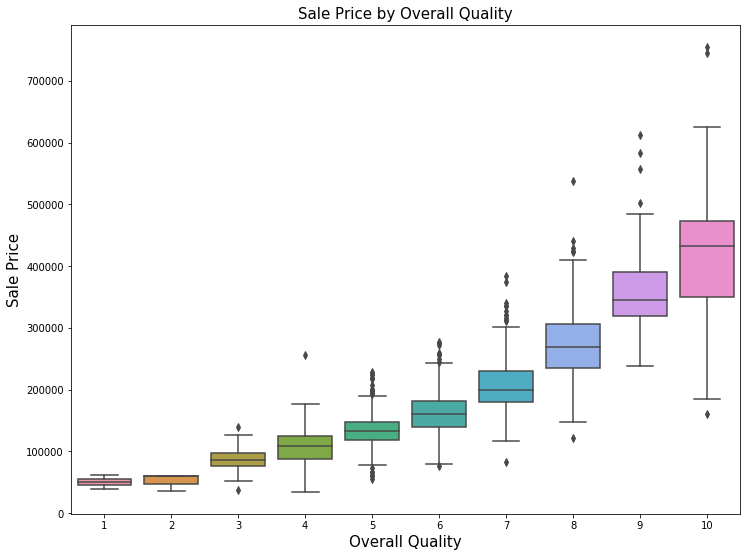

In [70]:
#Overall Quality boxplot
f, ax = plt.subplots(figsize=(12, 9))
sns.boxplot(x = 'OverallQual', y = 'SalePrice', data = train)
plt.xlabel('Overall Quality', fontsize=15)
plt.ylabel('Sale Price', fontsize=15)
plt.title('Sale Price by Overall Quality', fontsize=15)

From here we can see mostly what we might expect. We find that the higher the quality of a house, the more expensive it gets. And while there are a few observations outside of the whiskers, it doesn't look like there are any very significant outliers to worry about.

Text(0.5,1,'Sale Price by Living Area')

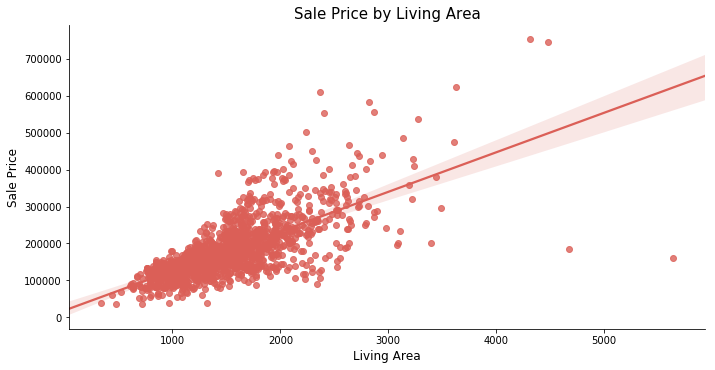

In [71]:
#Scatterplot looking at GrLivArea
sns.lmplot(x = 'GrLivArea', y = 'SalePrice', data = train, aspect = 2)
plt.xlabel('Living Area', fontsize=12)
plt.ylabel('Sale Price', fontsize=12)
plt.title('Sale Price by Living Area', fontsize=15)

Here we are looking mostly linear again although it looks like it might be following a little bit of an exponential path. There are also a few outliers that may throw off our predictions a little bit. We are going to get rid of those and then look at it again to see how it looks.

Text(0.5,1,'Sale Price by Living Area')

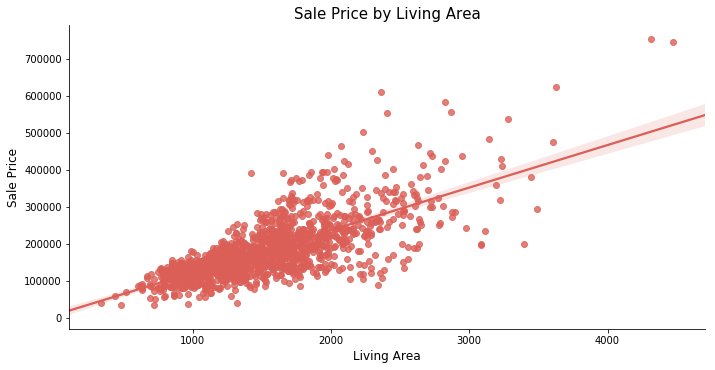

In [72]:
#Drop outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
sns.lmplot(x = 'GrLivArea', y = 'SalePrice', data = train, aspect = 2)
plt.xlabel('Living Area', fontsize=12)
plt.ylabel('Sale Price', fontsize=12)
plt.title('Sale Price by Living Area', fontsize=15)

Now we can see we removed the two outliers with huge GrLivArea and an extremely low sale price so that our model can focus on the normal cases for houses. Now we are going to visualize another important variable. The number of cars that fit in the garage.

Text(0.5,1,'Sale Price by Cars in Garage')

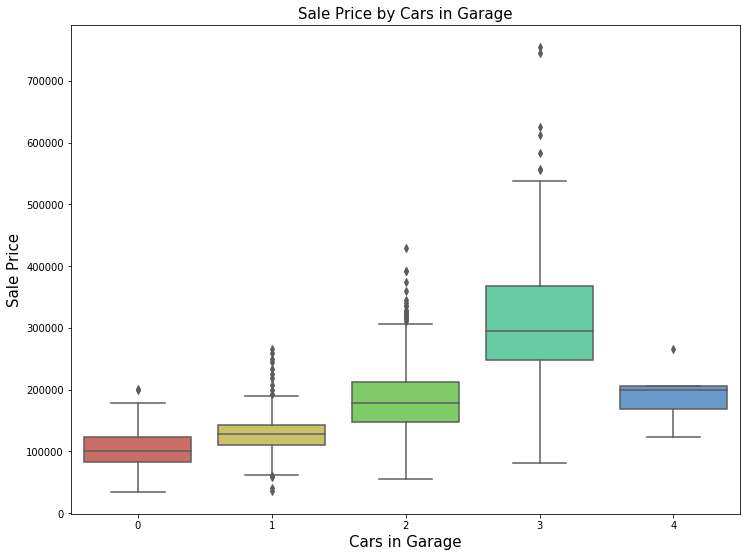

In [73]:
#Boxplot for GarageCars
f, ax = plt.subplots(figsize=(12, 9))
sns.boxplot(x = 'GarageCars', y = 'SalePrice', data = train)
plt.xlabel('Cars in Garage', fontsize=15)
plt.ylabel('Sale Price', fontsize=15)
plt.title('Sale Price by Cars in Garage', fontsize=15)

Once again we find mostly what we probably expected. The price trends upward as garages hold more cars until we get to the 4 car garages and our sale price takes a little bit of a dip. We can also see theat the 3 car garages have some really high sale prices which is good to know. We can probably expect most of our expensive houses to exhibit that characteristic. 

We will visualize the 1stFlrSF just to make sure nothing looks weird. We know it is highly correlated with the GrLivArea so we don't expect anything to different, but we will just make sure.

Text(0.5,1,'Sale Price by 1st Floor Square Footage')

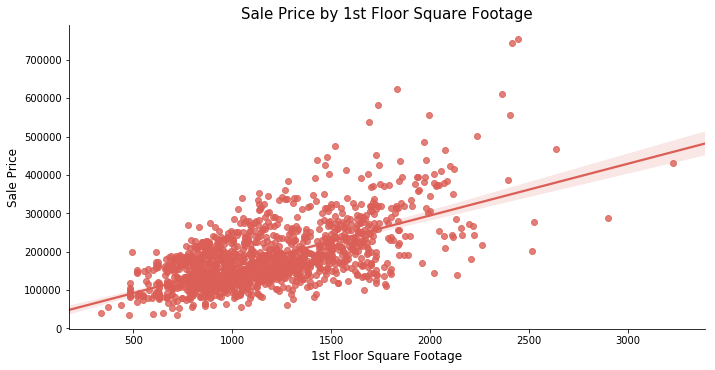

In [74]:
#Look at the first floor square footage
sns.lmplot(x = '1stFlrSF', y = 'SalePrice', data = train, aspect = 2)
plt.xlabel('1st Floor Square Footage', fontsize=12)
plt.ylabel('Sale Price', fontsize=12)
plt.title('Sale Price by 1st Floor Square Footage', fontsize=15)

Just as expected, the graph looks very similar to the first one we looked at. We are going to look at one more important variable, the total number of rooms.

Text(0.5,1,'Sale Price by Rooms Above Ground')

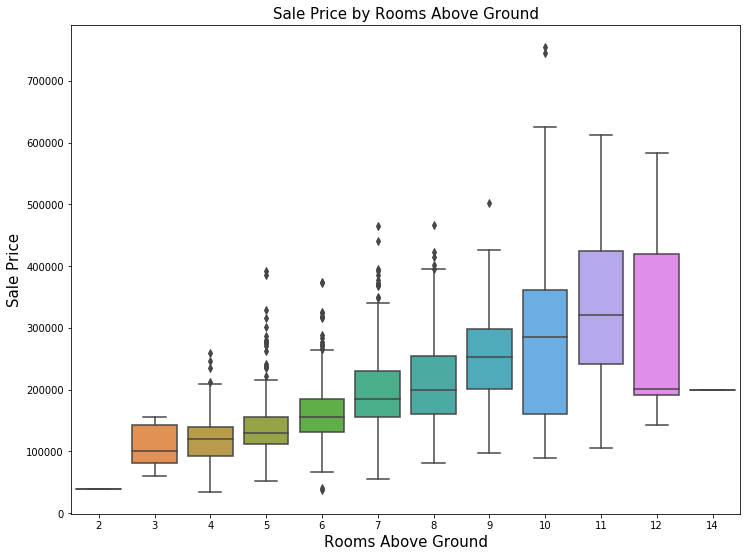

In [75]:
#Graph total rooms above ground
f, ax = plt.subplots(figsize=(12, 9))
sns.boxplot(x = 'TotRmsAbvGrd', y = 'SalePrice', data = train)
plt.xlabel('Rooms Above Ground', fontsize=15)
plt.ylabel('Sale Price', fontsize=15)
plt.title('Sale Price by Rooms Above Ground', fontsize=15)

Now we have a much better feel for a lot of the variables that have the largest impact on the Sale Price. There is a noticeable skew in a lot of the graphs that we looked at which will need to be fixed. We will take care of this when we do our feature engineering. 

Now let's look at our target variable, the SalePrice.

Text(0.5,1,'Sale Price Distribution')

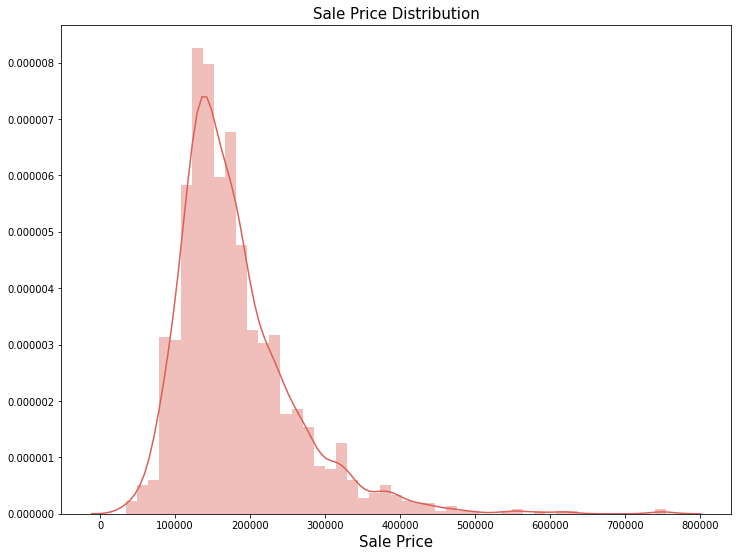

In [76]:
#Look at histogram of SalePrice
f, ax = plt.subplots(figsize=(12, 9))
sns.distplot(train.SalePrice)
plt.xlabel('Sale Price', fontsize=15)
plt.title('Sale Price Distribution', fontsize=15)

On this graph we see a long right tail. It is clearly not normally distributed. This is a problem because a lot of regression models like working with normal distributions and perform better this way. There are several ways that this could be handled. We are going to do a log transformation on our SalePrice and see if it normalizes our distribution.

Text(0.5,1,'Sale Price Distribution')

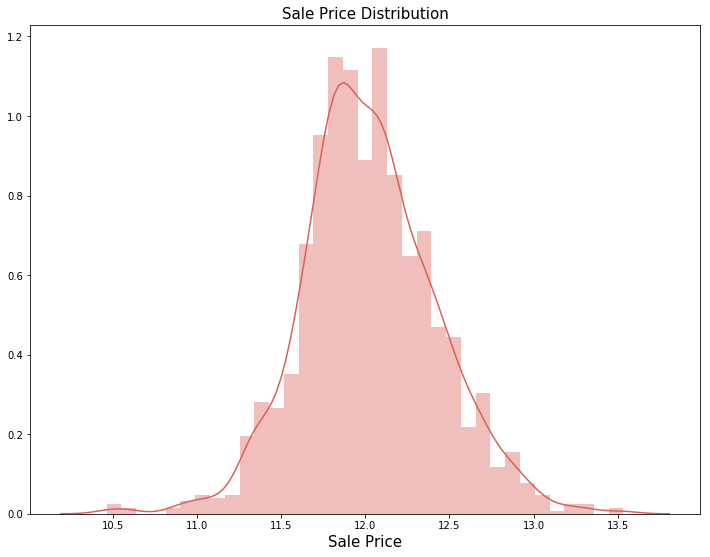

In [77]:
#Log transformation and graph again to show fixed distribution
train.SalePrice = np.log1p(train.SalePrice)
f, ax = plt.subplots(figsize=(12, 9))
sns.distplot(train.SalePrice)
plt.xlabel('Sale Price', fontsize=15)
plt.title('Sale Price Distribution', fontsize=15)

Our distribution looks much more normal now after a log transformation. We are going to go ahead and use our models to predict the log of SalePrice now and we will just have to make sure to change our predictions back to dollars when we are done.

# Imputation & Feature Engineering

The next thing we need to do in order to prepare our data for a predictive model is to check to make sure we are not missing any values, and do any feature engineering necessary to help our model make the best prediction. We are going to assign our target variable as our y values and merge our training and testing set so that any changes we make to one we can also make to the other. Then we will drop our target variable and Id variable because they won't do much for us at this time. 

Once we have our combined dataset, we will go ahead and look at which variables are missing values, and how many values they are missing. This will help us know what kind of work will be required to get a prediction-ready dataset.

In [78]:
#Set target variable as y, combine datasets, and drop unnecessary variables
y = train.SalePrice
n_train = train.shape[0]
data = pd.concat((train.drop('SalePrice', axis = 1), test)).reset_index(drop = True)
data = data.drop('Id', axis = 1)
data.shape

(2917, 79)

Text(0.5,1,'Percent missing data by feature')

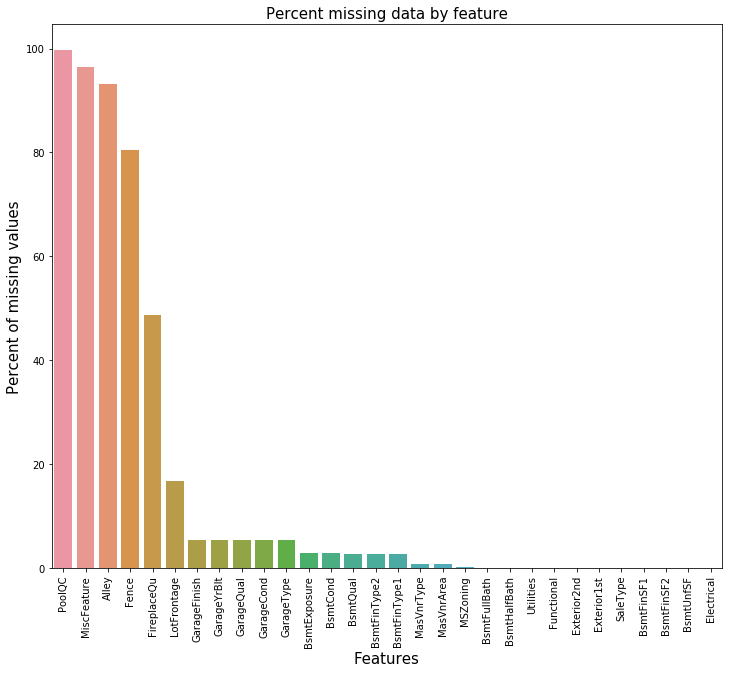

In [79]:
#Check to see missing values
#data.isna().sum().sort_values(ascending = False)[:35]
data_na = (data.isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='90')
sns.barplot(x=data_na.index, y = data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

Let's analyze which variables are missing. It will be a huge help to us to know what a lot of these variables mean. We can see that by looking at the data description file on Kaggle that accompanies this data. That can be found [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data).

Pool Quality is missing the most observations on our list, because it is missing so much we are just going to drop it seeing as it probably will tell us very little about our house prices.

We will also drop utilities because almost every single value in the dataset is the same, meaning it will not tell our model very much about home prices.

In [80]:
data = data.drop('PoolQC', axis = 1)
data = data.drop('Utilities', axis = 1)

## Imputation (Filling in Missing Values)

On our graph above, after all the large bars, we see a flat row for all of the Garage variables and another one for all of the basement variables. Looking in the documentation we can find that a missing value here means that the house simply does not have a garage or basement, meaning that there will be no garage or basement features. If we did not have such a detailed explanation this would still be fairly obvious and we could check it by looking at each row with a missing garage value to see it. 

Along with the garage and basement, I have compiled a list of all the other variables that have missing observations when that specific does not exist at a house. We are just going to fill all of these with "None".

In [81]:
#Use a for loop to quickly fill in the missing values for all of the categorical variables that don't exist
cat_missing = ['MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
              'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', "MasVnrType",
               'MSSubClass']
for col in cat_missing:
    data[col] = data[col].fillna('None')

There are also some variables that are numeric variables instead of categorical variables that do not exist in certain houses. For these we will just fill in a 0 in order to keep them numeric and easy to work with.

In [82]:
#Use a for loop to fill in the missing values for numerical variables
num_missing = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea', 'GarageCars',
               'GarageArea', 'GarageYrBlt']
for col in num_missing:
    data[col] = data[col].fillna(0)

A few values show that NA means that it the feature is typical. So we will fill these in with the appropriate abbreviation for typical as shown by the description.

In [83]:
data["Functional"] = data["Functional"].fillna("Typ")
data['KitchenQual'] = data['KitchenQual'].fillna("TA")

Now we have filled in all of the obvious missing values in our dataset as outlined by the data description. Next, we are going to look at the LotFrontage variable. We are going to have to figure out the best way to impute these values. We are going to group the houses by the neighborhood they are in and then fill in the missing values with the median of their neighborhood. This way it will be a little more accurate than using the median of the whole dataset. 

In [84]:
#Impute with median from neighborhood group
data["LotFrontage"] = data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

There are still a few more missing values in different columns. We are just going to fill in the most common value and not worry too much about what happens with them. Then we will make sure that we took care of all of our missing values.

In [85]:
fill_mode = ['MSZoning', 'SaleType', 'Exterior1st', 'Electrical', 'Exterior2nd']
for col in fill_mode:
    data[col] = data[col].fillna(data[col].mode()[0])

In [86]:
#Check for any more missing values
data.isnull().any().sum()

0

## Feature Engineering

Now we have the opportunity to create any new variables that might come in handy when predicting house prices. There is no surefire way to know which variables to create, so we will just create a few based off of intuition. Usually when buying a house, the total square footage matters, so we will create a variable for the total square footage of the house. We will also create a variable for how many bathrooms the house has. Lastly, a variable for how much porch space there is. Hopefully these will have an impact on our predictions.

In [87]:
#Create new variable for total square footage
data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']
data['Total_Bathrooms'] = (data['FullBath'] + (0.5*data['HalfBath']) + data['BsmtFullBath'] + (0.5*data['BsmtHalfBath']))
data['Total_porch_sf'] = (data['OpenPorchSF'] + data['3SsnPorch'] +data['EnclosedPorch'] 
                          + data['ScreenPorch'] + data['WoodDeckSF'])

Great! We filled in all of our missing values. Now we just have a few little final changes to make before our data is ready to be used to build a model. We are going to make sure that all of our variables are in a form that the machine learning algorithms can use. We are going to do that by enconding categorical variables that have some sort of hierarchy. So this applies to any variables that are ordered in an ascending order, such as the overall condition of the house.

To do this let's first look at what our variable types are and decide which ones might be right for each type of transformation. We are going to do this by going to the explanation of the data mentioned earlier an reviewing all of the variables.

In [88]:
#Change month and year to categorical features; also the condition of the house
data['YrSold'] = data['YrSold'].astype(str)
data['MoSold'] = data['MoSold'].astype(str)
data['OverallCond'] = data['OverallCond'].astype(str)
data['MSSubClass'] = data['MSSubClass'].apply(str)

#Label Encoder for categorical variables with order (such as those that are ranked 1-10)
cols = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold']
for i in cols:
        lbl = LabelEncoder()
        lbl.fit(list(data[i].values)) 
        data[i] = lbl.transform(list(data[i].values))

Now we are going to take care of the skew that we noticed in some of our predictor variables earlier. We need to identify which ones are skewed in a more mathematical way than just looking at pictures. We will use the scipy stats package to do this. Then we will use a [boxcox transformation](https://www.statisticshowto.datasciencecentral.com/box-cox-transformation/) to fix any of the skewed variables that we identify.

In [89]:
numeric_feats = data.dtypes[data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


In [90]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    data[feat] = boxcox1p(data[feat], lam)

There are 60 skewed numerical features to Box Cox transform


Now that the skewed variables have been corrected, we are going to get dummy variables for all of the remaining categorical variables. This will make it so we now are only working with numeric values.

In [91]:
#Get dummy variables
data = pd.get_dummies(data)
#Get new shape of data
data.shape

(2917, 221)

# Model Selection & Hyperparameter Tuning

First we are going to split all of our data back into our train and test data sets. Then we are going to set up our scoring metric. Since we are using the RMSE (the square root of the mean squared error), we will write a function to provide us with that score. We will also set up our function to plot learning curves for our models. This code was taken from the [learning curve page from scikit learn](http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html). We will use the learning curve to evaluate our models.

In [27]:
x = data[:n_train]
test = data[n_train:]

In [28]:
#Define scoring for our models
def get_rmse(model, x, y):
    scores = np.sqrt(-cross_val_score(model, x, y, cv = 5, scoring = 'neg_mean_squared_error'))
    return scores.mean()

In [29]:
#Function from sklearn for plotting learning curves
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = 'neg_mean_squared_error')
    train_scores_mean = np.mean(np.sqrt(-train_scores), axis=1)
    train_scores_std = np.std(np.sqrt(-train_scores), axis=1)
    test_scores_mean = np.mean(np.sqrt(-test_scores), axis=1)
    test_scores_std = np.std(np.sqrt(-test_scores), axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


### Models

Now it is time to decide which model we want to use to predict our house prices. We are going to use cross validation to get an idea for which models do the best job predicting and the learning curves to compare our training predictions and our testing predictions.

Let's understand what the models are we are looking at:

[Elastic Net](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html): The Elastic Net Model is a linear regression that weights L1 and L2 regularization according to model parameters. 

[Lasso](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso): The Lasso Model is a linear regression model that uses L1 regularization to make predictions. It tends to reduce coefficients so that predictions rely on less variables.

[Bayesian Ridge](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html#sklearn.linear_model.BayesianRidge): The Bayesian Ridge Model is a linear regression model that uses L2 regularization and Bayesian Methods to make predictions.

[Random Forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html): The Random Forest Model is an ensemble estimator using groups of decision trees built with bootstrapping to make predictions.

[XGBoost](https://xgboost.readthedocs.io/en/latest/parameter.html): The XGBoost Regressor is a ensemble of gradient boosted decision trees.

[SVR](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html): The Support Vector Regression Model depends only on a subset of the training data, because the cost function for building the model ignores any training data close to the model prediction.

[LightGB](https://lightgbm.readthedocs.io/en/latest/Quick-Start.html): The LightGB Regressor is another ensemble of gradient boosted decision trees that is slightly faster and sometimes more accurate than XGBoost.

[Kernel Ridge](http://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html): The Kernel Ridge Model is a linear regression model that uses Ridge Regression while applying the [kernel trick](http://www.chioka.in/explain-to-me-what-is-the-kernel-trick/).

[Gradient Boosting Regressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html): The Gradient Boosting Regressor is another decision tree boosted model.



ElasticNet : RMSE = 0.37694568663113376


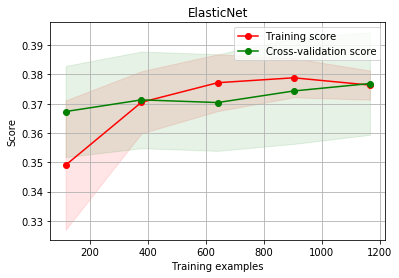

Lasso : RMSE = 0.3994682097577765


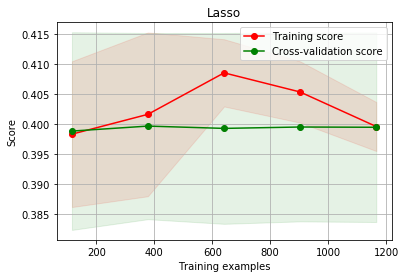

BayesianRidge : RMSE = 0.11610204479158001


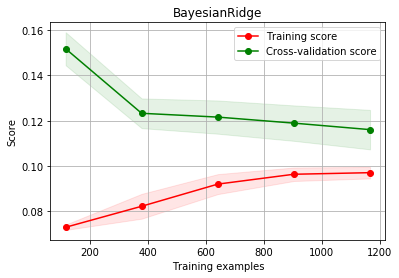

RandomForestRegressor : RMSE = 0.14581424663471124


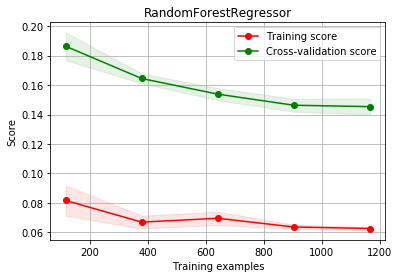

XGBRegressor : RMSE = 0.11937149122755712


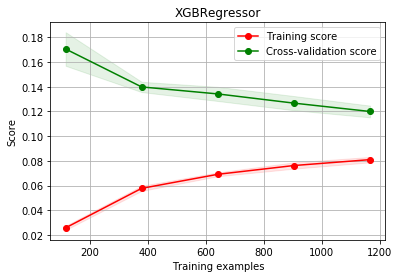

SVR : RMSE = 0.1532967705228126


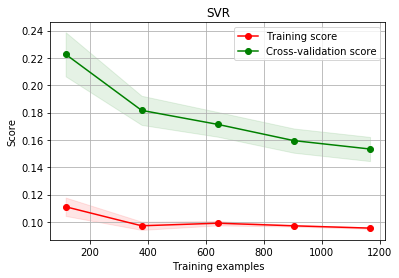

LGBMRegressor : RMSE = 0.12528293126425197


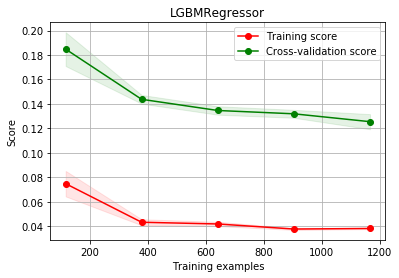

KernelRidge : RMSE = 0.1188098997241493


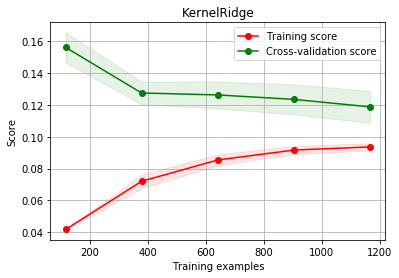

GradientBoostingRegressor : RMSE = 0.12047058582394943


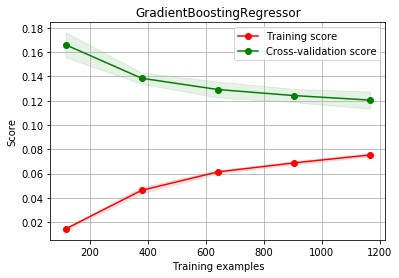

In [30]:
#Loop through models and compare results
en = ElasticNet()
lr = Lasso()
br = BayesianRidge()
rf = RandomForestRegressor()
xgbm = XGBRegressor()
svr = SVR()
lgbm = lgb.LGBMRegressor()
krr = KernelRidge()
gb = GradientBoostingRegressor()
reg = [en, lr, br, rf, xgbm, svr, lgbm, krr, gb]
#Use cross validation with the root mean squared error to get an idea of which models will work best for this problem
for model in reg:
    scores = get_rmse(model, x, y)
    print(model.__class__.__name__,": RMSE =", scores)
    plot_learning_curve(model, model.__class__.__name__, x, y, cv = 5)
    plt.show()

So what do we see from our results? Let's look at both the RMSE and the learning curve and see what they tell us.

**Lasso and Elastic Net**: These both have extremely high RMSEs compared to the other models. When we look at their learning curves, they are all over the place and probably underfitting since the training score was worse than the test score. This can most likely be fixed by adjusting the learning rate. Since these are theoretically good models for this kind of problem, we are going to keep them and adjust them later on.

**Bayesian Ridge, XGBoost, Kernel Ridge, Gradient Boosting Regressor**: These models actually performed fairly well. There is quite a bit of deviation from the average with the cross validation score on the Bayesian Ridge Model and a few of the models are still probably overfitting a little, but in general they all show good scores.We can also see that the two scores converge as we get more training data. If we had more data, we might expect our test scores to continue to improve. Unfortunately, we don't have more data, but we are going to do some tunining to see if we can improve our outcomes.

**Random Forest, LGBM, SVR**: These models are all showing pretty severe cases of overfitting. They score very high on the training sets and much lower on the test sets. They just don't generalize well to other data. We are not going to use any of these models except for the LGBM going forward. 


### Hyperparameter Tuning
We are going to use a RandomizedSearchCV to find the best hyperparameters for each model. I am also going to do some manual tuning for models based on what we saw from the learning curves above. We are going to set up a function to get the best parameters, and then set up the pipelines for each model.

In [31]:
#Function for getting the best hyperparameters for each model
def tune_parameters(pipe, x, y, params, n_iter, base_model):
    orig_score = get_rmse(base_model, x, y)
    model = RandomizedSearchCV(pipe, param_distributions = params, n_iter = n_iter, cv = 5, scoring = 'neg_mean_squared_error')
    start_time = time.time()
    model.fit(x,y)
    print("--- Finding the best hyperparameters took %s seconds --- \n" % (time.time() - start_time))
    print("--- Best Hyperparameters for %s --- \n" % (pipe.named_steps.model.__class__.__name__))
    print(model.best_params_, '\n')
    model = model.best_estimator_
    new_score = get_rmse(model, x, y)
    print('----- SCORE IMPROVEMENTS ----- \n')
    print("The original RMSE was %s \n" %(orig_score))
    print("The RMSE after finding the best parameters is %s \n" %(new_score))
    print("That is an improvement of %s \n" %(orig_score - new_score))
    print("----- NEW LEARNING CURVE -----")
    plot_learning_curve(model, pipe.named_steps.model.__class__.__name__, x, y, cv = 5)
    plt.show()
    return model

In [32]:
#Create the steps for each of the model pipelines
select = SelectKBest(k = 'all')
en_steps = [('Scaler', RobustScaler()), ('feature_selection', select), ('model', ElasticNet(alpha = .0005))]
lr_steps = [('Scaler', RobustScaler()), ('model', Lasso(alpha = .0005))]
xgb_steps = [('feature_selection', select), ('model', xgbm)]
lgb_steps = [('feature_selection', select), ('model', lgbm)]

#Build Pipelines
en_pipe = Pipeline(en_steps)
lr_pipe = Pipeline(lr_steps)
xgb_pipe = Pipeline(xgb_steps)
lgb_pipe = Pipeline(lgb_steps)

In [33]:
#Set up parameters for each pipeline to search through
params = {'xgb' : {'feature_selection__k' : np.arange(10,220, 10),
                  'model__n_estimators' : np.arange(100, 2000, 100),
                  'model__learning_rate' : np.arange(.01, .5, .01),
                  'model__gamma' : np.arange(0, 1, .01),
                  'model__max_depth' : np.arange(3, 10, 1),
                  'model__min_child_weight' : np.arange(0, 10, 1),
                  'model__colsample_bytree' : np.arange(.1, 1, .1)},
         'en' : {'feature_selection__k' : np.arange(10,220, 10),
                'model__l1_ratio' : np.arange(0, 1, .1),
                'model__selection' : ['cyclic', 'random']},
         'lr' : {'model__max_iter' : np.arange(700, 1400, 100),
                'model__selection' : ['cyclic', 'random']},
         'lgb' : {'feature_selection__k' : np.arange(10,220, 10),
                 'model__n_estimators' : np.arange(500, 3000, 200),
                  'model__learning_rate' : np.arange(.01, .5, .01),
                  'model__max_depth' : np.arange(3,8,1),
                  'model__colsample_bytree' : np.arange(.1, 1, .1)}
         }

In [34]:
#xgb_model = tune_parameters(xgb_pipe, x, y, params['xgb'], 50, xgb)

The random search for the XGBoost took a long time so I put it in here and changed some things. This one was overfitting some so we added some regularization to the model by changing our lambda and alpha. Along with this, we could also use early stopping rounds while fitting the model to help minimize the overfitting even more, but we are not going to do that here.

In [35]:
xgb_model = XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.1, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             nthread = -1)

--- Finding the best hyperparameters took 7.749981641769409 seconds --- 

--- Best Hyperparameters for Lasso --- 

{'model__selection': 'random', 'model__max_iter': 700} 

----- SCORE IMPROVEMENTS ----- 

The original RMSE was 0.3994682097577765 

The RMSE after finding the best parameters is 0.11148562420277122 

That is an improvement of 0.28798258555500533 

----- NEW LEARNING CURVE -----


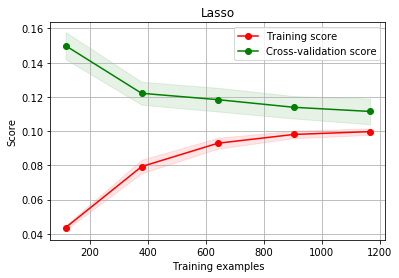

In [36]:
lasso = tune_parameters(lr_pipe, x, y, params['lr'], 10, lr)

--- Finding the best hyperparameters took 7.091865539550781 seconds --- 

--- Best Hyperparameters for ElasticNet --- 

{'model__selection': 'cyclic', 'model__l1_ratio': 0.8, 'feature_selection__k': 190} 

----- SCORE IMPROVEMENTS ----- 

The original RMSE was 0.37694568663113376 

The RMSE after finding the best parameters is 0.1116397695017565 

That is an improvement of 0.26530591712937723 

----- NEW LEARNING CURVE -----


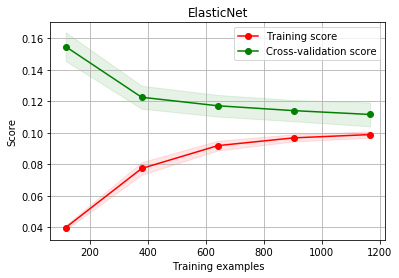

In [37]:
en_model = tune_parameters(en_pipe, x, y, params['en'], 10, en)

Both our Lasso and Elastic Net models look significantly better! And we have the parameters we need now to train them on our full data and use them for predictions!

In [38]:
#lgb_model = tune_parameters(lgb_pipe, x, y, params['lgb'], 50, lgb)

The LGB Regressor Model also was overfitting a lot so we change some of the paramters to help with that. By adding a bagging fraction and bagging frequency we help the model reduce overfitting and our learning curve looks significantly better than it did before tuning.

<module 'matplotlib.pyplot' from 'C:\\Users\\nelso\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

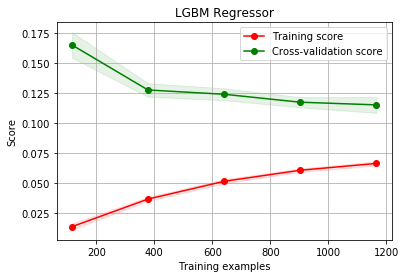

In [39]:
lgb_model = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

plot_learning_curve(lgb_model, "LGBM Regressor", x, y, cv = 5)

I took some suggestions from the documentation of scikit learn to tune our Gradient Boosting Regressor and Kernel Ridge Regressor.

In [40]:
gb_model = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

### Understanding our Models
Before we use our models to make predictions, we are going to try to understand what they are doing. To do this we are going to look at our Lasso Model. By looking at the coefficients of our model, we can see what variables had the largest impact on our final prediction. This is important for being able to interpret our model if we needed to explain our predictions to someone else. It also tells us if our feature engineering was productive or if our new features did not have a large impact. So we are going to create a new dataframe with our coefficients and variable names and then graph them. 

In [41]:
lr_model = Lasso(alpha = .0005)
lr_model.fit(x.values, y.values)
feature_importances = pd.DataFrame(columns = ['Variable', 'Coef'])
feature_importances['Variable'] = list(x)
feature_importances['Coef'] = abs(lr_model.coef_)
feature_importances.sort_values(by = 'Coef', ascending = False, inplace = True)
feature_importances = feature_importances[0:10]
feature_importances.head(15)

,Variable,Coef
60,MSZoning_C (all),0.264296
7,OverallQual,0.254935
8,OverallCond,0.164947
57,TotalSF,0.124331
96,Neighborhood_StoneBr,0.087630
34,KitchenAbvGr,0.077335
80,Neighborhood_Crawfor,0.076903
24,CentralAir,0.075791
58,Total_Bathrooms,0.072214
42,GarageCars,0.065671


Text(0.5,1,'Most Important Features in Lasso Model')

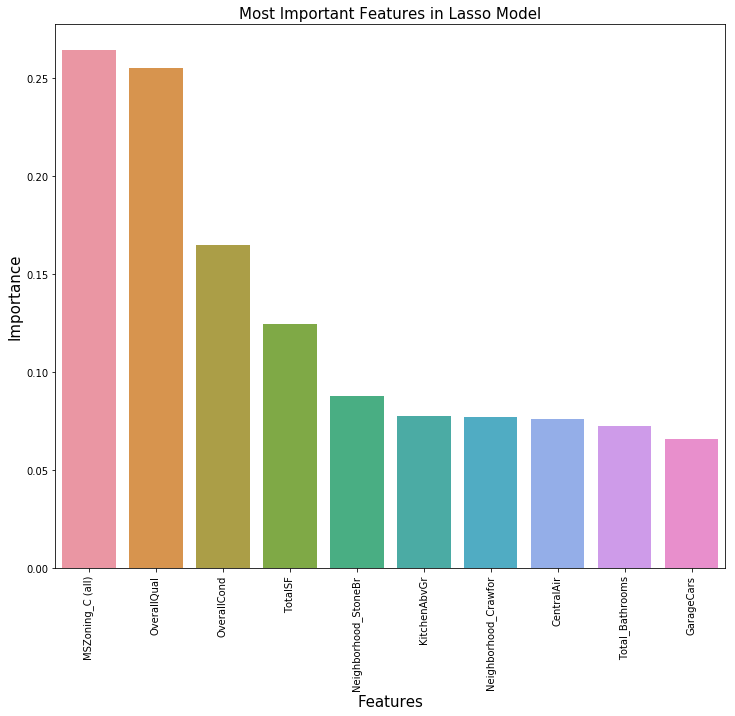

In [92]:
f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='90')
sns.barplot(x=feature_importances['Variable'], y = feature_importances['Coef'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Importance', fontsize=15)
plt.title('Most Important Features in Lasso Model', fontsize=15)

So what does this tell us? First of all we can see the ten most important variables. Some of these are not surprising, such as Overall Quality and Overall prediction. Some of the other variables might give us some extremely important details if we were interested in explaining to a decision-maker what our predictions depend on. We also can see the Total_Bathrooms variable we created had a significant impact on our model. This doesn't mean our other variables didn't matter, but they weren't the most important.

Now we understand a little bit more about how our models are working, we are going to fit our new models on our entire training dataset so they are ready to predict. We are training all 7 models right now even though we are only going to use one to predict the values of our test set for right now. Our Lasso model performed best in cross validation so we are going to use that one to make and submit our predictions.

In [43]:
en_model = en_model.fit(x.values,y.values)
krr_model = krr.fit(x.values,y.values)
gb_model = gb_model.fit(x.values,y.values)
lr_model = lasso.fit(x.values, y.values)
xgb_model = xgb_model.fit(x.values, y.values)
lgb_model = lgb_model.fit(x.values, y.values)
br_model = br.fit(x.values, y.values)

In [44]:
#Prediction scored .11856
lasso_pred = np.expm1(lr_model.predict(test.values))
submission = pd.DataFrame({'Id':Id,'SalePrice':lasso_pred})
submission.to_csv("submission.csv",index=False)

# Stacking Models

So one model gave us a pretty decent score of .11856 RMSE. Multiple models can be more powerful than one though. We are going to try stacking our models in a few different ways in order to improve our score. When stacking models, it is usually good to stack models that are somewhat different from each other. So first we are going to see how all of our predictions are related with a heatmap.

In [45]:
#Make predictions and combine into dataframe
xgb_pred = np.expm1(xgb_model.predict(test.values))
lgb_pred = np.expm1(lgb_model.predict(test.values))
br_pred = np.expm1(br_model.predict(test.values))
en_pred = np.expm1(en_model.predict(test.values))
gb_pred = np.expm1(gb_model.predict(test.values))
krr_pred = np.expm1(krr_model.predict(test.values))

predictions = pd.DataFrame({"XGBoost":xgb_pred.ravel(), "Elastic Net":en_pred.ravel(), "Bayesian Ridge": br_pred.ravel(),
                            "LightGB": lgb_pred.ravel(), "Gradient Boosting": gb_pred.ravel(), "Lasso": lasso_pred.ravel(),
                           "Kernel": krr_pred.ravel()})

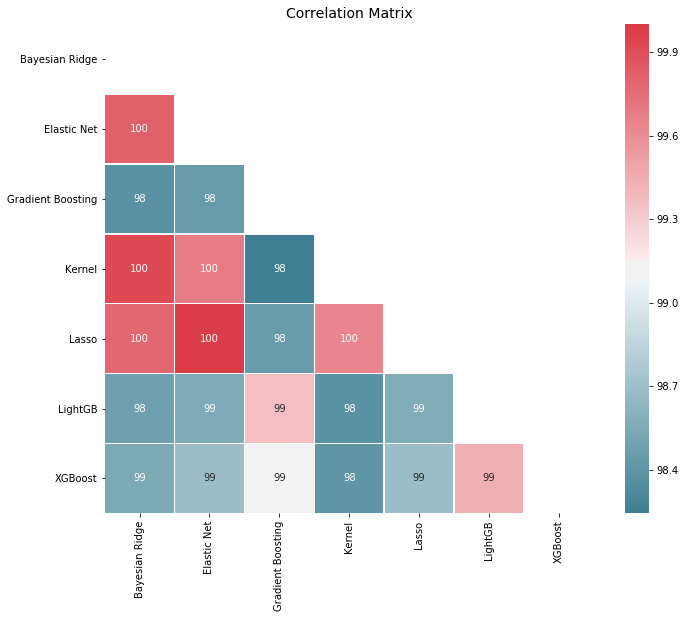

<function matplotlib.pyplot.show>

In [93]:
corrmat(predictions.corr())
plt.show

So this correlation map doesn't show us too much. They are all pretty highly correlated. We at least see some that are a little different from each other which gives us a starting place. 

The first kind of stacking we are going to try is averaging models together. Through some trial and error I found the best combination of 4 models and averaged them to get a better score. Let's see how much of an improvement we made.

In [47]:
finalMd = (np.expm1(lr_model.predict(test.values)) + np.expm1(en_model.predict(test.values)) 
           + np.expm1(krr_model.predict(test.values)) + np.expm1(gb_model.predict(test.values))) / 4
finalMd

array([119892.34895607, 155813.20007826, 186813.9405147 , ...,
       171766.2458158 , 116647.83113876, 222930.60741868])

In [48]:
#Scored .11584
submission = pd.DataFrame({'Id':Id,'SalePrice':finalMd})
submission.to_csv("submission.csv",index=False)

Our score improved to .11584! That is a pretty impressive improvement! Now we are going to try some more advanced stacking. We are using the [mlens package](http://ml-ensemble.com/) to stack our models. Basically the way this works, is that we get predictions from several models, and use a meta model to predict our outcome from those. If you would like to read more about how this works you can do so [here](http://blog.kaggle.com/2016/12/27/a-kagglers-guide-to-model-stacking-in-practice/).

We are going to do a train test split to see how our stacked model performs before throwing it out into the real world.

In [49]:
x_train, x_test, y_train, y_test = train_test_split(x, y)

So we are using a stacked model of our Elastic Net, Kernel Ridge, and Gradient Boosting Regressor, with our meta model being our Lasso model in order to predict our outcome.

In [50]:
#Stacking
sl = SuperLearner(
    scorer = rmse,
    folds=7,
    random_state=42,
    verbose=2,
)
sl.add([en_model, krr_model, gb_model])
sl.add_meta(lr_model)

SuperLearner(array_check=2, backend=None, folds=7,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=7270, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=7, raise_on_ex...3F8C378>)],
   n_jobs=-1, name='group-1', raise_on_exception=True, transformers=[])],
   verbose=1)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=42, sample_size=20,
       scorer=<function rmse at 0x000001E4C3F8C378>, shuffle=False,
       verbose=2)

In [51]:
sl.fit(x_train, y_train)
preds = sl.predict(x_test)
scores = mean_squared_error(y_test, preds)
scores = np.sqrt(scores)
print(scores)


Fitting 2 layers
Processing layer-1             done | 00:01:31
Processing layer-2             done | 00:00:00
Fit complete                        | 00:01:32

Predicting 2 layers
Processing layer-1             done | 00:00:02
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:04
0.10132145930771043


In [52]:
sl.fit(x.values, y.values)
ens_pred = np.expm1(sl.predict(test.values))
ens_pred


Fitting 2 layers
Processing layer-1             done | 00:01:43
Processing layer-2             done | 00:00:00
Fit complete                        | 00:01:44

Predicting 2 layers
Processing layer-1             done | 00:00:02
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:03


array([118704.69, 156030.66, 188303.55, ..., 170007.38, 115410.86,
       223352.53], dtype=float32)

Our stacked model scored an impressive .1097 on the training set. We are going to use this model and average it with our LGBModel in order to get our new score of .11500, which is another improvement from our averaged score. 

In [53]:
lgb_pred = np.expm1(lgb_model.predict(test.values))

In [54]:
#.11500
y_pred = .72*ens_pred + .28*lgb_pred

In [55]:
submission = pd.DataFrame({'Id':Id,'SalePrice':y_pred})
submission.to_csv("submission.csv",index=False)